In [2]:
import numpy as np
import pandas as pd

from datetime import date

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

## Final Functions
parameters:
- sample size: N
- seed for randomization
- train-test split ratio

In [144]:
## Note: csv_file is not included in the repo

def get_sample(csv_file, N, seed):
    np.random.seed(seed)
    ratings = pd.read_csv(csv_file)
    
    #keep only ratings from the most recent 5 years： 2010-2015
    ratings['year'] = ratings['timestamp'].apply(lambda x: date.fromtimestamp(x).year)
    ratings = ratings[ratings['year']>=date.fromisoformat('2010-01-01').year]
    ratings.drop(['timestamp','year'],axis=1,inplace=True) #'timestamp' and 'year' no longer useful 
    
    #keep only movies with at least 20 ratings
    m_counts = ratings.groupby('movieId').size()
    m_index = m_counts[m_counts>=20].index
    ratings = ratings[ratings['movieId'].isin(m_index)]
    
    #keep only users who have rated at least 20 movies - consistent with original data
    u_counts = ratings.groupby('userId').size()
    u_index = u_counts[u_counts>=20].index
    ratings = ratings[ratings['userId'].isin(u_index)]
    
    #sample out N users
    users = np.unique(ratings['userId'])
    u_index_sample = np.random.choice(users, N)
    sample = ratings[ratings['userId'].isin(u_index_sample)]
    
    #keep a percentage of ratings for each user: 30% -- lower variance
    pct = pd.DataFrame(columns=['userId','movieId','rating'])
    u_N, u_rating_count = np.unique(sample['userId'], return_counts=True)
    
    for i in range(len(u_N)):
        u_id = u_N[i]
        u_sample = sample[sample['userId']==u_id]
        u_sample = u_sample[u_sample['movieId'].isin(np.random.choice(np.unique(u_sample['movieId']),
                                                                      int(u_rating_count[i]*0.3)))]
        pct = pct.append(u_sample)
    
    sample = pct
    
#     #plot data
#     users_s, u_count_s = np.unique(sample['userId'], return_counts=True)
#     plt.plot(np.arange(1, len(users_s)+1), sorted(sample.groupby('userId').size(), reverse=True))
#     plt.xlabel('number of users')
#     plt.ylabel('number of rated movies')
#     plt.show()
    
    print('number of unique users:', len(np.unique(sample['userId'])))
    print('number of unique movies:', len(np.unique(sample['movieId'])))
    
    return sample


In [145]:
sample = get_sample('ratings.csv', 500, 1)

number of unique users: 494
number of unique movies: 4191


In [146]:
sample.head()

,userId,movieId,rating
10993,99,1,4.0
10999,99,480,3.0
11011,99,1261,4.0
11015,99,2454,3.0
11020,99,2959,5.0


In [147]:
def get_train_test(sample_data, split, seed):
    np.random.seed(seed)
    sample = sample_data
    
    train, test = train_test_split(sample, test_size=split)
    
    #check
    print('number of users in train:',len(np.unique(train['userId'])))
    print('number of movies in train:',len(np.unique(train['movieId'])))
    print('number of users in test:', len(np.unique(test['userId'])))
    print('number of movies in test:',len(np.unique(test['movieId'])))
    
    return train, test
    

In [148]:
train, test = get_train_test(sample, 0.3, 1)

number of users in train: 494
number of movies in train: 3599
number of users in test: 469
number of movies in test: 2288


In [73]:
train.head()

,userId,movieId,rating
16888171,116803,3435,4.0
13230553,91414,8360,4.0
12537759,86643,2340,2.5
171099,1163,300,3.0
4347079,29638,8865,3.0


## Process

In [39]:
ratings = pd.read_csv('ratings.csv')
# ratings.drop(['timestamp'],axis=1,inplace=True)
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [40]:
ratings['year'] = ratings['timestamp'].apply(lambda x: date.fromtimestamp(x).year)
# ratings.sort_values('datetime', ascending=False, inplace=True)

In [41]:
ratings.head()

,userId,movieId,rating,timestamp,year
0,1,2,3.5,1112486027,2005
1,1,29,3.5,1112484676,2005
2,1,32,3.5,1112484819,2005
3,1,47,3.5,1112484727,2005
4,1,50,3.5,1112484580,2005


In [44]:
ratings.groupby('year').size()

year
1995          4
1996    1613004
1997     700639
1998     308018
1999    1198736
2000    1954193
2001    1186433
2002     869506
2003    1035777
2004    1170590
2005    1802450
2006    1171664
2007    1053496
2008    1159547
2009     929235
2010     903351
2011     766886
2012     731866
2013     598515
2014     562904
2015     283449
dtype: int64

In [45]:
ratings = ratings[ratings['year']>=date.fromisoformat('2010-01-01').year]
print(ratings.shape)
print(ratings.head())
ratings.groupby('year').size()

(3846971, 5)
      userId  movieId  rating   timestamp  year
1175      11     4226     5.0  1294796159  2011
1231      11     5971     5.0  1294796201  2011
1239      11     6291     5.0  1294796113  2011
1267      11     7153     5.0  1294796132  2011
1315      11    30707     5.0  1294796176  2011


year
2010    903351
2011    766886
2012    731866
2013    598515
2014    562904
2015    283449
dtype: int64

In [46]:
ratings.drop(['timestamp','year'],axis=1,inplace=True)
ratings.head()

,userId,movieId,rating
1175,11,4226,5.0
1231,11,5971,5.0
1239,11,6291,5.0
1267,11,7153,5.0
1315,11,30707,5.0


In [12]:
users, u_count = np.unique(ratings_1015['userId'], return_counts=True)
print(len(users))
movies, m_count = np.unique(ratings_1015['movieId'], return_counts=True)
print(len(movies))

30779
26302


In [47]:
#check for movie counts
counts = ratings.groupby('movieId').size()
counts.describe()

count    26302.000000
mean       146.261539
std        592.770155
min          1.000000
25%          2.000000
50%          8.000000
75%         44.000000
max      14023.000000
dtype: float64

In [48]:
#remove movies with less than 20 ratings - too few ratings are meaningless
m_index = counts[counts>=20].index
ratings = ratings[ratings['movieId'].isin(m_index)]
ratings.head()

,userId,movieId,rating
1175,11,4226,5.0
1231,11,5971,5.0
1239,11,6291,5.0
1267,11,7153,5.0
1315,11,30707,5.0


In [49]:
#check for movie counts
counts = ratings.groupby('movieId').size()
counts.describe()

count     9359.000000
mean       401.589807
std        941.435553
min         20.000000
25%         38.000000
50%         89.000000
75%        316.000000
max      14023.000000
dtype: float64

In [50]:
#check for user counts
ratings.groupby('userId').size().describe()

count    30773.000000
mean       122.135606
std        182.982088
min          1.000000
25%         29.000000
50%         60.000000
75%        138.000000
max       3605.000000
dtype: float64

In [51]:
#mostly above 20 ratings
u_counts = ratings.groupby('userId').size()
u_index = u_counts[u_counts>=20].index
ratings = ratings[ratings['userId'].isin(u_index)]
print(ratings.shape)

(3744597, 3)


In [52]:
#down from 30773 to 29080 - still adequate
users = np.unique(ratings['userId'])
print(len(users))
movies = np.unique(ratings['movieId'])
print(len(movies))

29080
9359


In [ ]:
# testing = ratings_1015.drop(['timestamp','datetime'],axis=1)
# testing.head()

In [58]:
np.random.seed(1)
u_index_sample = np.random.choice(users,50)
print(len(u_index_sample))
sample = ratings[ratings['userId'].isin(u_index_sample)]

50


In [59]:
len(np.unique(sample['userId']))

50

In [60]:
sample.head()

,userId,movieId,rating
102342,713,110,2.5
102343,713,260,4.0
102344,713,527,4.5
102345,713,1188,4.0
102346,713,1760,3.5


In [61]:
users_sample, u_count_sample = np.unique(sample['userId'], return_counts=True)
print(len(users_sample))
movies_sample, m_count_sample = np.unique(sample['movieId'], return_counts=True)
print(len(movies_sample))

50
2187


In [62]:
sample.groupby('userId').count().sort_values('movieId',ascending=False)

,movieId,rating
userId,,
106989,721,721
1163,390,390
16417,307,307
91414,250,250
29638,242,242
12353,213,213
103506,209,209
2085,189,189
92178,184,184


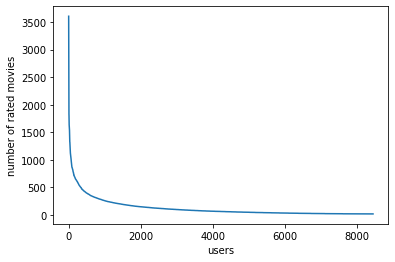

In [24]:
plt.plot(np.arange(1, len(users_sample)+1), sorted(sample.groupby('userId').size(), reverse=True))
plt.xlabel('users')
plt.ylabel('number of rated movies')
plt.show()

In [140]:
pct1 = pd.DataFrame(columns=['userId','movieId','rating'])
u_N, u_rating_count = np.unique(sample['userId'], return_counts=True)

In [141]:
for i in range(len(u_N)):
    u_id = u_N[i]
    u_sample = sample[sample['userId']==u_id]
    u_sample = u_sample[u_sample['movieId'].isin(np.random.choice(np.unique(u_sample['movieId']),
                                                                  int(u_rating_count[i]*0.1)))]
    pct1 = pct1.append(u_sample)

In [125]:
print(len(pct['userId'].unique()))
print(len(pct['movieId'].unique()))

494
4969


In [136]:
#keep 50%
pct.groupby('movieId').size().describe()

count    5016.000000
mean        5.019537
std         8.111020
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max        98.000000
dtype: float64

In [139]:
#keep 30%
pct3.groupby('movieId').size().describe()

count    4203.000000
mean        3.927195
std         5.587471
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        59.000000
dtype: float64

In [149]:
pct3.groupby('userId').size().describe()

count    494.000000
mean      33.412955
std       48.137560
min        3.000000
25%        7.250000
50%       16.000000
75%       39.750000
max      440.000000
dtype: float64

In [142]:
#keep 10%
pct1.groupby('movieId').size().describe()

count    2563.000000
mean        2.313305
std         2.419139
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        22.000000
dtype: float64

In [127]:
sample.groupby('movieId').size().describe()

count    6766.000000
mean        9.457139
std        17.856110
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       225.000000
dtype: float64

### Train Test Split

In [63]:
# _50p = sample.groupby('userId').size().describe()[5]
# _50p
sample.groupby('userId').size().describe()

count     50.000000
mean      95.500000
std      125.113867
min       20.000000
25%       26.500000
50%       36.500000
75%      139.250000
max      721.000000
dtype: float64

In [ ]:
#no longer needed to set a minimum threshold
# print(len(users3),len(users3[u_count3<_50p]))
# user_train_ind = users3[u_count3<_50p]
# user_train_ind2 = users3[u_count3>=_50p]
# train1 = sample[sample['userId'].isin(user_train_ind)]

In [ ]:
# train1

In [26]:
# train, test = train_test_split(sample[sample['userId'].isin(user_train_ind2)], test_size = 0.3)
train, test = train_test_split(sample, test_size = 0.3)

In [ ]:
# train = train1.append(train2)

In [27]:
print(len(np.unique(sample['userId'])))
print(len(np.unique(sample['movieId'])))
sample.shape

8450
9359


(1077204, 3)

In [28]:
print(len(np.unique(train['userId'])))
print(len(np.unique(train['movieId'])))
train.shape

8450
9349


(754042, 3)

In [29]:
print(len(np.unique(test['userId'])))
print(len(np.unique(test['movieId'])))
test.shape

8448
9138


(323162, 3)